In [1]:
import smooth_component_analysis as sca
from importlib import reload
reload(sca)
import numpy as np
import pandas as pd
import get_db_data as gdd

from scipy.stats import zscore
import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
sago = sca.savitzky_golay([1001, 1004, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
                          1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051],
                          21,11,2,3)

In [3]:
sago45 = sca.savitzky_golay([1001, 1004, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
                          1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051],
                          45,11,2,3)

In [4]:
df21 = sago.get_aligned_signal_componets()

x range: 4.0 222.0


In [5]:
df45 = sago45.get_aligned_signal_componets()

x range: 4.0 222.0


In [6]:
sg_range = {c: df45[c] - df21[c] for c in df45.columns if c[1].startswith("resid_")}

In [7]:
df = pd.DataFrame(sg_range)
df.columns = pd.MultiIndex.from_tuples(df.columns)

In [8]:
df.head()

1001                          1004                          1006  \
  resid_101 resid_102 resid_103 resid_110 resid_111 resid_112 resid_116   
0 -0.514597 -1.008194 -1.098447 -0.635000  0.432185 -0.609158 -1.062801   
1 -0.432991 -0.871844 -0.955469 -0.564550  0.363726 -0.554658 -0.952844   
2 -0.351385 -0.735495 -0.812491 -0.494099  0.295266 -0.500158 -0.842888   
3 -0.269779 -0.599145 -0.669514 -0.423648  0.226806 -0.445658 -0.732931   
4 -0.188173 -0.462796 -0.526536 -0.353197  0.158347 -0.391157 -0.622974   

                           1007  ...      1048      1049                      \
  resid_117 resid_118 resid_119  ... resid_247 resid_248 resid_249 resid_250   
0  0.048075 -0.075974 -0.512030  ...  0.292451 -0.209725 -0.657592 -0.061497   
1  0.012032 -0.061768 -0.460623  ...  0.266843 -0.185086 -0.584111 -0.048013   
2 -0.024012 -0.047562 -0.409215  ...  0.241236 -0.160447 -0.510630 -0.034529   
3 -0.060055 -0.033357 -0.357808  ...  0.215629 -0.135809 -0.437148 -0.021046   
4 -0.096098 -0.019151 -0.306401  ...  0.190021 -0.111170 -0.363667 -0.007562   

       1050                          1051                      
  resid_251 resid_252 resid_253 resid_254 resid_255 resid_256  
0 -0.070040 -0.997178 -0.180215 -0.092909  0.312245  0.628307  
1 -0.074588 -0.883031 -0.165708 -0.096370  0.261004  0.562670  
2 -0.079136 -0.768884 -0.151201 -0.099831  0.209762  0.497032  
3 -0.083684 -0.654738 -0.136694 -0.103292  0.158520  0.431395  
4 -0.088232 -0.540591 -0.122187 -0.106752  0.107278  0.365758  

[5 rows x 60 columns]

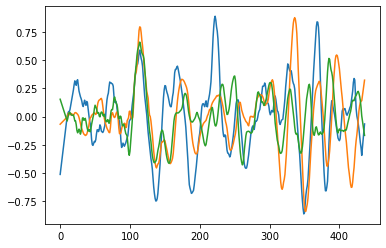

In [9]:
plt.plot(df[1007])

In [10]:
df21.columns[:10]

MultiIndex([(1001,   'Raw_101'),
            (1001,    'Sg_101'),
            (1001, 'resid_101'),
            (1001,   'rms_101'),
            (1001,  'rmso_101'),
            (1001,   'Raw_102'),
            (1001,    'Sg_102'),
            (1001, 'resid_102'),
            (1001,   'rms_102'),
            (1001,  'rmso_102')],
           )

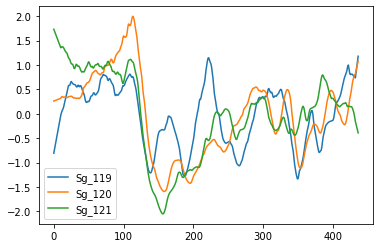

In [11]:
plt.plot(df21[1007].iloc[:,1::5]) # only sg columns
plt.legend(df21[1007].iloc[:,1::5].columns)

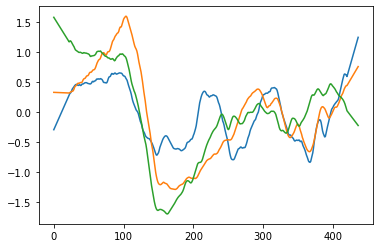

In [12]:
plt.plot(df45[1007].iloc[:,1::5]) # only sg columns

In [40]:
fnorm = lambda m: (m**2).sum()

In [110]:
def group_sync(df, group, series_type):
    colnames = [a for a in df.columns if a[0]==group and a[1].startswith(series_type)]
    signals = [zscore(df[a]) for a in colnames]
    gs = ((signals[0]*signals[1]*signals[2])**2)**(1/3)/len(df)
    return gs*100

In [111]:
def temporal_sync_plot(df, group,series_type):
    colnames = [a for a in df.columns if a[0]==group and a[1].startswith(series_type)]
    signals = [zscore(df[a]) for a in colnames]
    print([len(s) for s in signals])
    plt.figure(figsize=(8,6))
    for sig in signals:
        plt.plot(sig+4)
    plt.legend([s[1] for s in colnames])
    n = len(signals[0])
    tas = [temporal_agreement(signals[i],signals[j])*100 for (i, j) in [(0,1),(0,2),(1,2)]] 
    
    colors = [(1,0,0), (0.4940, 0.1840, 0.5560), (0.6350, 0.0780, 0.1840)]
    for ta,shft,clr in zip(tas,range(3),colors):
        plt.plot(ta-shft)
        plt.plot([0,n],[-shft,-shft],'--',color=clr)
        
    total_sync = group_sync(df, group, series_type) #np.power(tas[0]*tas[1]*tas[2],1/3)
#     gp = fnorm(total_sync/1e4-((signals[0]*signals[1]*signals[2])**2)**(1/3)/n)
#     if gp > 0.005:
#         return fnorm(total_sync)/1e4, fnorm(np.power(np.power(signals[0]*signals[1]*signals[2],2),1/3)/n), gp
    plt.plot(total_sync-4)
    plt.plot([0,n],[-4,-4],'--',color=(0.4660, 0.6740, 0.1880))
    
def temporal_agreement(sig1, sig2):
    if type(sig1)==tuple:
        sig1 = df[sig1]
    if type(sig2)==tuple:
        sig2 = df[sig2]
    zs1 = zscore(sig1)
    zs2 = zscore(sig2)
    n = zs1.shape[0]
    return zs1*zs2/n

[437, 437, 437]


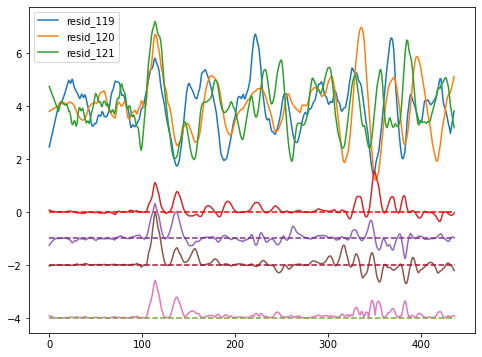

In [86]:
temporal_sync_plot(df,1007,'resid_')

[437, 437, 437]


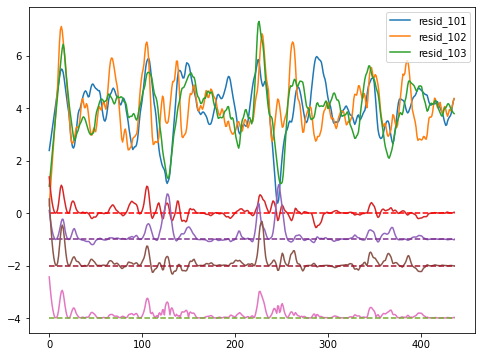

In [87]:
temporal_sync_plot(df,1001,'resid_')

[437, 437, 437]


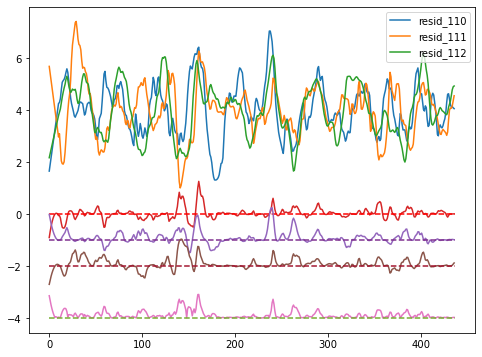

In [30]:
temporal_sync_plot(df,1004,'resid_')

[437, 437, 437]


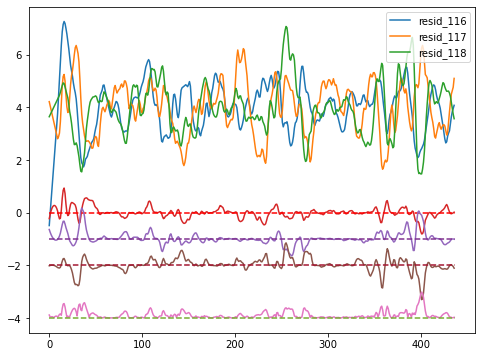

In [31]:
temporal_sync_plot(df,1006,'resid_')

[437, 437, 437]


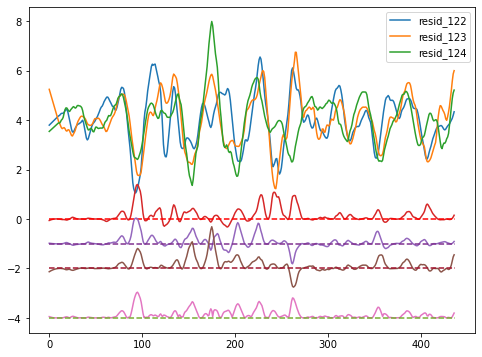

In [32]:
temporal_sync_plot(df,1008,'resid_')

[437, 437, 437]


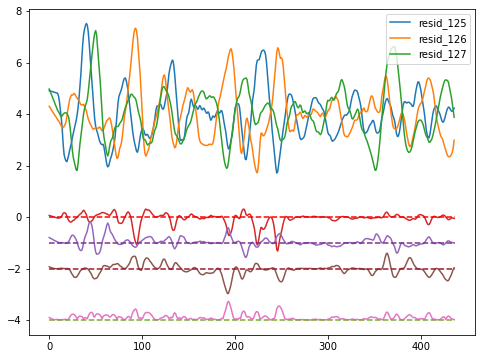

In [33]:
temporal_sync_plot(df,1009,'resid_')

[437, 437, 437]


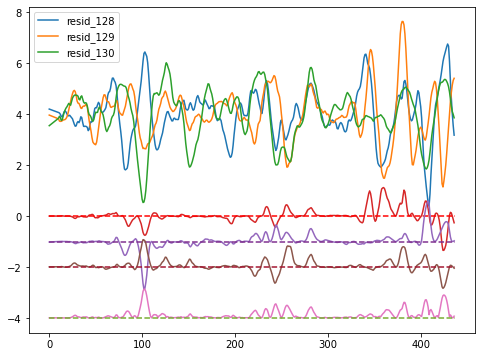

In [34]:
temporal_sync_plot(df,1010,'resid_')

[437, 437, 437]


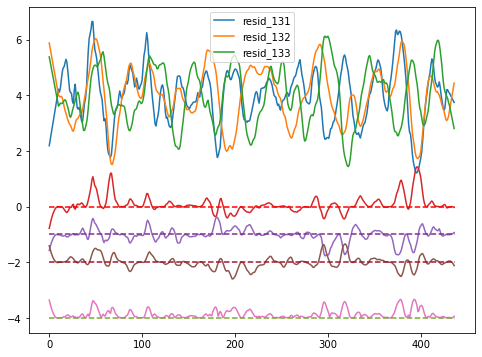

In [35]:
temporal_sync_plot(df,1011,'resid_')

[437, 437, 437]


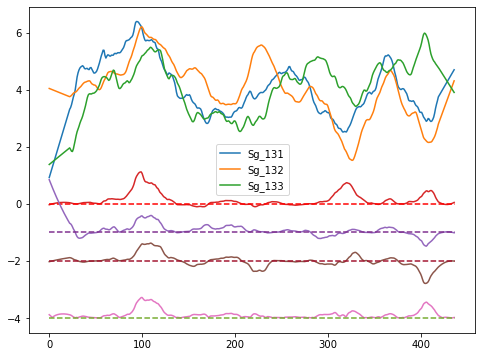

In [36]:
temporal_sync_plot(df45,1011,'Sg_')

[437, 437, 437]


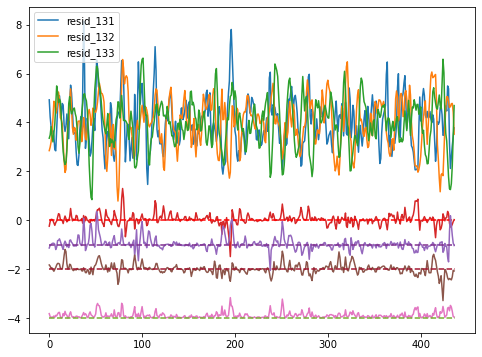

In [37]:
temporal_sync_plot(df21,1011,'resid_')

[437, 437, 437]


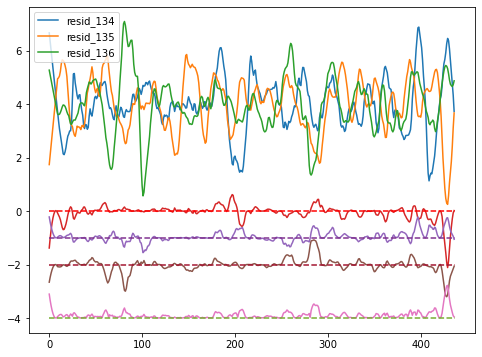

In [38]:
temporal_sync_plot(df,1012,'resid_')

[437, 437, 437]


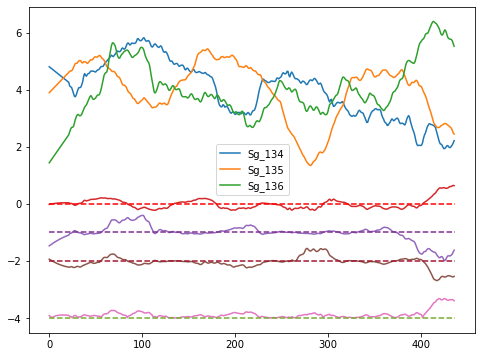

In [39]:
temporal_sync_plot(df45,1012,'Sg_')

[437, 437, 437]


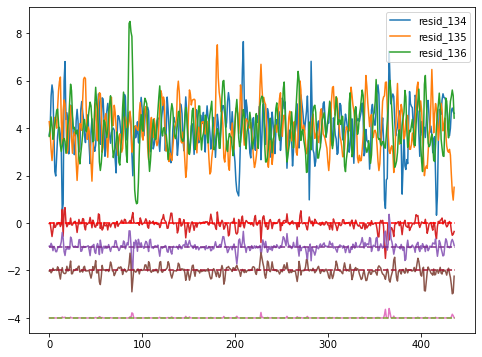

In [26]:
temporal_sync_plot(df21,1012,'resid_')

In [42]:
df.corr()

1001                          1004                      \
               resid_101 resid_102 resid_103 resid_110 resid_111 resid_112   
1001 resid_101  1.000000  0.280365  0.695961  0.131783 -0.254206 -0.129730   
     resid_102  0.280365  1.000000  0.510542 -0.063749 -0.235147 -0.200641   
     resid_103  0.695961  0.510542  1.000000  0.157033 -0.360131 -0.124645   
1004 resid_110  0.131783 -0.063749  0.157033  1.000000  0.115208  0.436940   
     resid_111 -0.254206 -0.235147 -0.360131  0.115208  1.000000  0.402092   
     resid_112 -0.129730 -0.200641 -0.124645  0.436940  0.402092  1.000000   
1006 resid_116  0.131700  0.424152  0.371644  0.006802 -0.282222 -0.131863   
     resid_117 -0.190436 -0.100954 -0.059477  0.044911  0.329424  0.212191   
     resid_118 -0.215945  0.167708 -0.046199 -0.222092 -0.337260 -0.267463   
1007 resid_119  0.040559 -0.069328  0.074295  0.333438  0.144500  0.246694   
     resid_120 -0.003819 -0.103405  0.056600  0.179018  0.104885  0.233080   
     resid_121 -0.086726 -0.064784 -0.053935 -0.021629 -0.163330  0.156765   
1008 resid_122  0.331847  0.282883  0.381330  0.003463 -0.131806 -0.145274   
     resid_123  0.093950  0.280750  0.174857 -0.264841 -0.062618 -0.109314   
     resid_124  0.084642  0.162943  0.126016 -0.194548  0.174043  0.157106   
1009 resid_125  0.149935  0.050455 -0.019850  0.069819  0.188659  0.236908   
     resid_126 -0.330962 -0.371891 -0.365565 -0.047821  0.074242  0.044767   
     resid_127 -0.243164 -0.217059 -0.280840  0.010244  0.016469 -0.000105   
1010 resid_128  0.259141  0.367210  0.274994  0.065172  0.019962 -0.163470   
     resid_129 -0.029798  0.055872 -0.030516  0.023697  0.192487  0.126493   
     resid_130  0.000173 -0.053537 -0.018086  0.004776 -0.020240  0.255536   
1011 resid_131  0.117352  0.109316  0.042456 -0.061195 -0.032805 -0.165504   
     resid_132  0.088193 -0.048564 -0.005663 -0.131948 -0.041951 -0.171409   
     resid_133 -0.024735 -0.045222  0.010920  0.281989 -0.177100 -0.076428   
1012 resid_134  0.002122 -0.175045  0.036031 -0.146620 -0.013712 -0.097326   
     resid_135  0.119662  0.264502  0.301201  0.008010 -0.305203 -0.165352   
     resid_136 -0.269678 -0.281776 -0.129249 -0.198948 -0.185108  0.057908   
1013 resid_137 -0.400903  0.057781 -0.339936 -0.126784  0.238263  0.099538   
     resid_138 -0.345087 -0.156959 -0.370996 -0.162609  0.062996  0.099297   
     resid_139 -0.292262  0.254125 -0.075836  0.040092  0.005634  0.170477   
1042 resid_227 -0.279281  0.078052 -0.138059 -0.060794 -0.126052 -0.041830   
     resid_228  0.302301  0.390275  0.331659 -0.044555 -0.323387 -0.244619   
     resid_229  0.014133 -0.097078  0.147275  0.160397 -0.136743  0.178245   
1043 resid_230  0.050817 -0.082920  0.209460  0.034982 -0.127493  0.123981   
     resid_231  0.152888  0.188792  0.287028  0.003127  0.197702  0.011230   
     resid_232 -0.069537  0.017420 -0.032823  0.036947 -0.144049 -0.160673   
1044 resid_233  0.150690  0.062745  0.070058 -0.063933 -0.241869  0.053024   
     resid_234  0.097434 -0.145906  0.162396  0.497425  0.010656  0.251115   
     resid_235  0.011518 -0.128393 -0.133929 -0.045981 -0.176110  0.143635   
1045 resid_236 -0.501430 -0.097362 -0.457251 -0.041178  0.277420  0.233634   
     resid_237  0.262038  0.165301  0.134111 -0.142163 -0.147324 -0.144388   
     resid_238 -0.493993 -0.308005 -0.614956  0.137524  0.025725  0.176847   
1046 resid_239  0.065196 -0.276282 -0.028838 -0.092367  0.166842  0.137863   
     resid_240  0.147734  0.414550  0.260993 -0.222678 -0.115050 -0.285772   
     resid_241  0.140099 -0.009156  0.124497  0.393351  0.098968  0.333099   
1047 resid_242  0.176079  0.053091  0.104763 -0.003001 -0.002721  0.202050   
     resid_243 -0.309604 -0.205497 -0.319814  0.069247 -0.052595  0.301973   
     resid_244 -0.059037  0.146759 -0.021040 -0.155266  0.126442 -0.202955   
1048 resid_245 -0.172579 -0.282674 -0.087399  0.017432  0.056540  0.057914   
     resid_246  0.106135  0.042892  0.1437

In [43]:
sago.__dict__

{'group_ids': [1001,
  1004,
  1006,
  1007,
  1008,
  1009,
  1010,
  1011,
  1012,
  1013,
  1042,
  1043,
  1044,
  1045,
  1046,
  1047,
  1048,
  1049,
  1050,
  1051],
 'f1_length': 21,
 'f2_length': 11,
 'series_type': 2,
 'interp_type': 3,
 'df':          1001                                                              \
       Raw_101    Sg_101 resid_101   rms_101  rmso_101   Raw_102    Sg_102   
 0   -2.534640 -0.975463 -1.559177  1.089043  0.931150 -3.086362 -0.445385   
 1   -2.248808 -0.858407 -1.390401  1.162591  1.023645 -2.687924 -0.315255   
 2   -1.628996 -0.741351 -0.887645  1.216359  1.096361 -1.458749 -0.185126   
 3   -0.904911 -0.624295 -0.280615  1.231060  1.130009  0.143468 -0.054997   
 4   -0.226828 -0.507239  0.280412  1.199075  1.116971  1.519564  0.075133   
 ..        ...       ...       ...       ...       ...       ...       ...   
 432  0.087678 -0.228632  0.316310  0.449717  0.412709 -1.057301 -0.266024   
 433 -0.108447 -0.217255  0.108808  0.415032

In [45]:
sago1 = sca.savitzky_golay([],21,11,3,2)

In [46]:
sago1.df = df
sago1.group_ids = [1001, 1004, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
                          1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051]

In [51]:
corrs = list(sago1.yield_crossgroup_corr(True,'resid_',True))

(1001, 'resid_101') (1001, 'resid_102')
(1001, 'resid_101') (1001, 'resid_103')
(1001, 'resid_102') (1001, 'resid_103')
(1004, 'resid_110') (1004, 'resid_111')
(1004, 'resid_110') (1004, 'resid_112')
(1004, 'resid_111') (1004, 'resid_112')
(1006, 'resid_116') (1006, 'resid_117')
(1006, 'resid_116') (1006, 'resid_118')
(1006, 'resid_117') (1006, 'resid_118')
(1007, 'resid_119') (1007, 'resid_120')
(1007, 'resid_119') (1007, 'resid_121')
(1007, 'resid_120') (1007, 'resid_121')
(1008, 'resid_122') (1008, 'resid_123')
(1008, 'resid_122') (1008, 'resid_124')
(1008, 'resid_123') (1008, 'resid_124')
(1009, 'resid_125') (1009, 'resid_126')
(1009, 'resid_125') (1009, 'resid_127')
(1009, 'resid_126') (1009, 'resid_127')
(1010, 'resid_128') (1010, 'resid_129')
(1010, 'resid_128') (1010, 'resid_130')
(1010, 'resid_129') (1010, 'resid_130')
(1011, 'resid_131') (1011, 'resid_132')
(1011, 'resid_131') (1011, 'resid_133')
(1011, 'resid_132') (1011, 'resid_133')
(1012, 'resid_134') (1012, 'resid_135')


In [52]:
corrs

[(((1001, 'resid_101'), (1001, 'resid_102')), 0.28036502227923094),
 (((1001, 'resid_101'), (1001, 'resid_103')), 0.6959612956494373),
 (((1001, 'resid_102'), (1001, 'resid_103')), 0.5105423969873601),
 (((1004, 'resid_110'), (1004, 'resid_111')), 0.1152083712876618),
 (((1004, 'resid_110'), (1004, 'resid_112')), 0.4369395738429097),
 (((1004, 'resid_111'), (1004, 'resid_112')), 0.4020924531394614),
 (((1006, 'resid_116'), (1006, 'resid_117')), 0.00038780086972955616),
 (((1006, 'resid_116'), (1006, 'resid_118')), 0.14893752231849025),
 (((1006, 'resid_117'), (1006, 'resid_118')), 0.07987074329462661),
 (((1007, 'resid_119'), (1007, 'resid_120')), 0.44805072921057865),
 (((1007, 'resid_119'), (1007, 'resid_121')), 0.22521029617375785),
 (((1007, 'resid_120'), (1007, 'resid_121')), 0.3031395740473992),
 (((1008, 'resid_122'), (1008, 'resid_123')), 0.6537692539664105),
 (((1008, 'resid_122'), (1008, 'resid_124')), 0.34052723924216316),
 (((1008, 'resid_123'), (1008, 'resid_124')), 0.5572

In [53]:
group_corrs = {}
for o, item in enumerate(corrs):
    group_corrs[item[0][0][0]] = group_corrs.get(item[0][0][0],[])+ [item[1]]
group_corrs

{1001: [0.28036502227923094, 0.6959612956494373, 0.5105423969873601],
 1004: [0.1152083712876618, 0.4369395738429097, 0.4020924531394614],
 1006: [0.00038780086972955616, 0.14893752231849025, 0.07987074329462661],
 1007: [0.44805072921057865, 0.22521029617375785, 0.3031395740473992],
 1008: [0.6537692539664105, 0.34052723924216316, 0.5572405366905329],
 1009: [-0.28615397852455143, 0.1623561412976978, -0.1831490554460177],
 1010: [0.04880982657312824, 0.11748000632687974, 0.27706037572106734],
 1011: [0.3675248090422825, -0.1052223702128856, 0.0034088259737826603],
 1012: [-0.2646914918201772, 0.19921252107625773, -0.09946537963026116],
 1013: [0.4310243849771837, 0.4766389322258928, 0.48111467300661265],
 1042: [-0.0783434506830856, -0.06993144754679691, 0.1814893063301948],
 1043: [0.10106102655223047, 0.12215071734173819, -0.37220858267300033],
 1044: [0.034639861383504535, 0.6563611353157914, -0.01070462242545421],
 1045: [0.22360359311894976, 0.5384262343646637, 0.0319284348312454

In [62]:
group_corr_dir = { k: tuple(sorted([ c < -0.1 and -1 or (c > 0.1) and 1 or 0 for c in v])) for k, v in group_corrs.items()}

from collections import Counter
Counter(group_corr_dir.values()).most_common()

[((1, 1, 1), 6),
 ((0, 1, 1), 5),
 ((0, 0, 1), 4),
 ((-1, 0, 1), 3),
 ((-1, -1, 1), 1),
 ((-1, 1, 1), 1)]

In [88]:
data = gdd.get_db_data()
patric = data.get_participants(True, False)

group_cohes = {}
for item in patric:
    group_cohes[item[0]] = group_cohes.get(item[0],[]) + [float(item[2])]
group_cohes

{1001: [4.25, 5.0, 5.25],
 1003: [4.0, 1.5],
 1004: [3.5, 2.75, 3.75],
 1006: [4.0, 4.75, 3.25],
 1007: [3.25, 5.0, 4.75],
 1008: [6.0, 6.0, 4.75],
 1009: [5.5, 5.0, 4.0],
 1010: [4.75, 3.75, 3.25],
 1011: [5.0, 4.25, 6.0],
 1012: [1.0, 2.0, 4.25],
 1013: [3.75, 4.5, 4.25],
 1014: [3.0, 4.25, 5.0],
 1015: [2.75, 2.25],
 1016: [3.75, 2.75, 2.5],
 1017: [3.25, 3.75],
 1019: [5.0, 4.0, 2.0],
 1020: [2.25, 4.0, 4.0],
 1022: [3.75, 4.5, 4.75],
 1023: [4.5, 5.0, 5.5],
 1024: [5.0, 5.0, 4.0],
 1025: [4.75, 4.75, 4.25],
 1026: [5.0, 4.0, 5.0],
 1027: [4.0, 2.75, 2.0],
 1028: [4.0, 2.75],
 1029: [4.5, 5.25, 4.25],
 1030: [4.25, 4.25, 4.75],
 1031: [1.25, 3.5, 3.75],
 1032: [5.0, 5.25, 3.5],
 1033: [5.0, 4.0, 4.5],
 1034: [3.0, 1.0, 3.25],
 1035: [5.0, 3.0, 5.75],
 1036: [4.25, 3.75, 4.25],
 1037: [3.25, 5.5, 3.75],
 1038: [3.25, 4.75, 4.5],
 1039: [3.75, 3.5, 6.0],
 1040: [3.5, 1.25, 2.75],
 1041: [4.25, 2.75, 5.5],
 1042: [4.25, 3.75, 2.0],
 1043: [4.0, 5.25, 4.0],
 1044: [4.5, 5.0, 4.0],
 104

In [63]:
corr_dir_cohes = {}
for gr, sgn in group_corr_dir.items():
    corr_dir_cohes[sgn] = corr_dir_cohes.get(sgn,[])+group_cohes[gr]

sorted([(k, (np.array(v)).max()) for k, v in corr_dir_cohes.items()], key=lambda x: x[0], reverse=True) 

[((1, 1, 1), 6.0),
 ((0, 1, 1), 6.0),
 ((0, 0, 1), 5.0),
 ((-1, 1, 1), 5.25),
 ((-1, 0, 1), 6.0),
 ((-1, -1, 1), 5.5)]

In [64]:
group_cohes_df = pd.DataFrame(data=group_cohes.items(), columns = ['GroupId','all'])
group_cohes_df.head()

group_cohes_df = pd.DataFrame(data=group_cohes.items(), columns = ['GroupId','all'])

group_cohes_df['Coher'] = group_cohes_df['all'].map(np.array)
group_cohes_df['MinCoh'] =group_cohes_df['all'].map(np.min)
group_cohes_df['MidCoh'] =group_cohes_df['all'].map(lambda v: np.sort(v)[1])
group_cohes_df['MaxCoh'] =group_cohes_df['all'].map(np.max)

group_cohes_df['CorrDir'] = group_cohes_df.apply(lambda r: group_corr_dir.get(r[0]), axis=1)
group_cohes_df.head()

,GroupId,all,Coher,MinCoh,MidCoh,MaxCoh,CorrDir
0,1001,"[4.25, 5.0, 5.25]","[4.25, 5.0, 5.25]",4.25,5.00,5.25,"(1, 1, 1)"
1,1003,"[4.0, 1.5]","[4.0, 1.5]",1.50,4.00,4.00,None
2,1004,"[3.5, 2.75, 3.75]","[3.5, 2.75, 3.75]",2.75,3.50,3.75,"(1, 1, 1)"
3,1006,"[4.0, 4.75, 3.25]","[4.0, 4.75, 3.25]",3.25,4.00,4.75,"(0, 0, 1)"
4,1007,"[3.25, 5.0, 4.75]","[3.25, 5.0, 4.75]",3.25,4.75,5.00,"(1, 1, 1)"


In [65]:
group_cohes_df.groupby('CorrDir')['MaxCoh'].mean()

#group_cohes_df.groupby('CorrDir')['MinCoh'].mean()

#group_cohes_df.groupby('CorrDir')['MidCoh'].mean() 

CorrDir
(-1, -1, 1)    5.500000
(-1, 0, 1)     4.750000
(-1, 1, 1)     5.250000
(0, 0, 1)      4.625000
(0, 1, 1)      5.150000
(1, 1, 1)      4.833333
Name: MaxCoh, dtype: float64

In [66]:
group_cohes_df.groupby('CorrDir')['MinCoh'].mean()


CorrDir
(-1, -1, 1)    4.000000
(-1, 0, 1)     2.750000
(-1, 1, 1)     4.000000
(0, 0, 1)      3.250000
(0, 1, 1)      4.300000
(1, 1, 1)      3.541667
Name: MinCoh, dtype: float64

In [67]:
group_cohes_df.groupby('CorrDir')['MidCoh'].mean() 

CorrDir
(-1, -1, 1)    5.000000
(-1, 0, 1)     3.416667
(-1, 1, 1)     4.000000
(0, 0, 1)      4.062500
(0, 1, 1)      4.550000
(1, 1, 1)      4.625000
Name: MidCoh, dtype: float64

In [108]:
focus_groups = [1001, 1004, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
                          1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051]
                          

In [113]:
gs

{1001: 60.684498459250705,
 1004: 55.736617983886006,
 1006: 53.05676422500527,
 1007: 56.30376998982763,
 1008: 61.399554953454185,
 1009: 46.36394533903114,
 1010: 56.055261241783576,
 1011: 60.20642955773225,
 1012: 49.66224162217627,
 1013: 58.77051017615404,
 1042: 42.51050503938647,
 1043: 51.903422809558805,
 1044: 56.80265426346076,
 1045: 51.99510546069331,
 1046: 51.563918844998,
 1047: 44.62053037837999,
 1048: 54.30631593053148,
 1049: 51.54343116510617,
 1050: 58.00855441866946,
 1051: 49.11706223565507}

In [103]:
[a for a in df.columns if a[0]==1004 and a[1].startswith('resid_')]

[(1004, 'resid_110'), (1004, 'resid_111'), (1004, 'resid_112')]

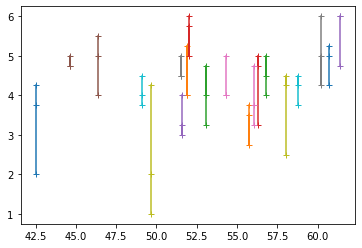

In [134]:
gs = {gid: group_sync(df, gid,'resid_').sum() for gid in focus_groups}

x = [];y= []
for gid in focus_groups:
    x += [gs[gid]]*3
    y += group_cohes[gid]
    plt.plot([gs[gid]]*3,group_cohes[gid],'+-')

x=np.array(x).reshape(-1,1)
y = np.array(y)

In [141]:

from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x,y)

model.coef_, model.intercept_

(array([0.04291703]), 1.9734609053078507)

{1001: 58.85358458301055,
 1004: 50.73274041582242,
 1006: 62.19598435894477,
 1007: 72.42499401271736,
 1008: 56.976841023484724,
 1009: 48.79465684179323,
 1010: 67.2069755653954,
 1011: 54.42605817767942,
 1012: 52.59808219456754,
 1013: 58.760937137813904,
 1042: 75.95414706810601,
 1043: 72.11156071427861,
 1044: 56.031939159301714,
 1045: 53.85228619403852,
 1046: 60.38528041494673,
 1047: 52.02190257936308,
 1048: 54.93441660220179,
 1049: 59.547969596943624,
 1050: 49.18520472290153,
 1051: 65.3707497993386}

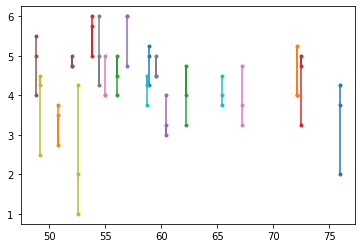

In [122]:
gs45 = {gid: group_sync(df45, gid,'Sg_').sum() for gid in focus_groups}
for gid in focus_groups:
    plt.plot([gs45[gid]]*3,group_cohes[gid],'.-')
gs45


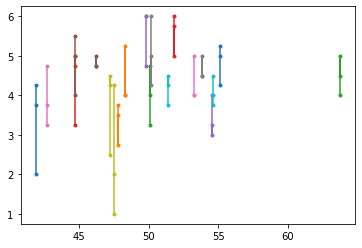

In [123]:
gs21 = {gid: group_sync(df21, gid,'resid_').sum() for gid in focus_groups}
for gid in focus_groups:
    plt.plot([gs21[gid]]*3,group_cohes[gid],'.-')


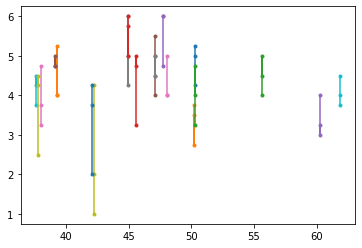

In [124]:
gs21 = {gid: group_sync(df21, gid,'rmso_').sum() for gid in focus_groups}
for gid in focus_groups:
    plt.plot([gs21[gid]]*3,group_cohes[gid],'.-')

[437, 437, 437]
[1.0, 2.0, 4.25]


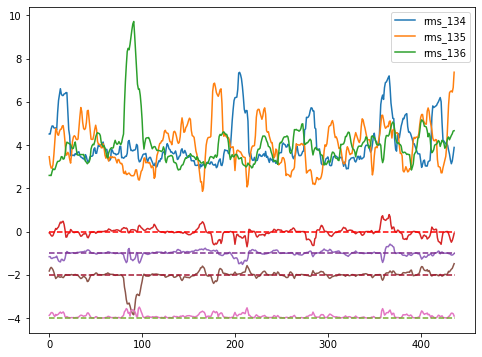

In [143]:
temporal_sync_plot(df21,1012,'rms_')
print(group_cohes[1012])

[437, 437, 437]
[4.25, 5.0, 5.25]


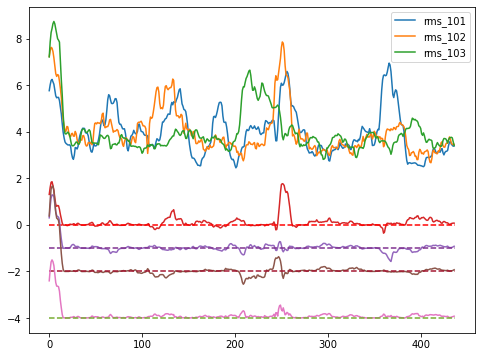

In [144]:
temporal_sync_plot(df21,1001,'rms_')
print(group_cohes[1001])

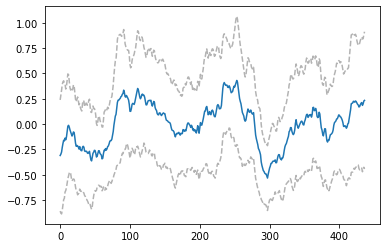

In [158]:
m = df21[[c for c in df21.columns if c[1].startswith("rms_")]].apply(zscore,axis=0).mean(axis=1)
s = df21[[c for c in df21.columns if c[1].startswith("rms_")]].apply(zscore,axis=0).std(axis=1)

plt.plot(m)
plt.plot(m+s/2,'--', color=[0.7]*3)
plt.plot(m-s/2,'--', color=[0.7]*3)


[437, 437, 437]
[3.5, 2.75, 3.75]


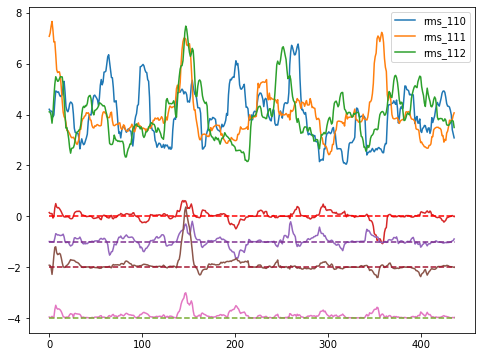

In [159]:
temporal_sync_plot(df21,1004,'rms_')
print(group_cohes[1004])

[437, 437, 437]
[4.0, 4.75, 3.25]


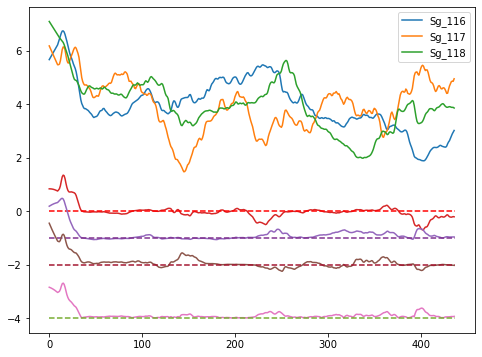

In [164]:
temporal_sync_plot(df21,1006,'Sg_')
print(group_cohes[1006])

[437, 437, 437]
[3.25, 5.0, 4.75]


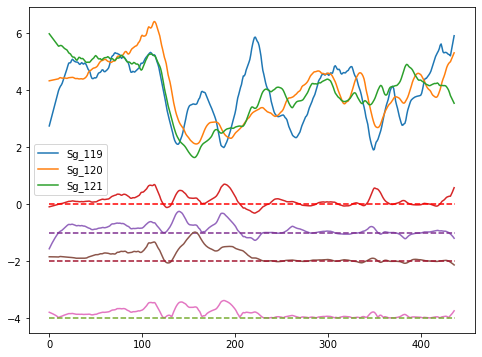

In [165]:
temporal_sync_plot(df21,1007,'Sg_')
print(group_cohes[1007])

[437, 437, 437]
[3.25, 5.0, 4.75]


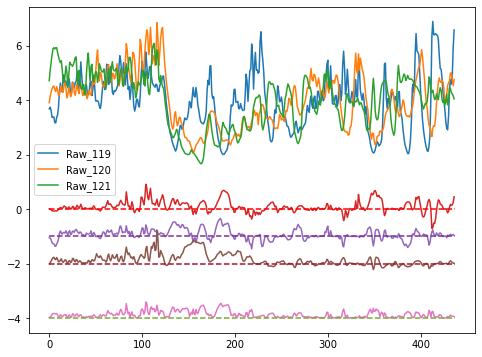

In [168]:
temporal_sync_plot(df21,1007,'Raw_')
print(group_cohes[1007])